In [1]:
from fastai.text.all import *
import pandas as pd
cols = ["sentiment","text"]
df = pd.read_csv("data/all-data.csv", names =cols, encoding = "ISO-8859-1")
df_test = pd.read_csv("data/public-test-set.csv", names = cols, encoding = "ISO-8859-1")
df_all = pd.concat([df, df_test])

In [2]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

In [4]:
def clean_text(in_df):
    #Remove words which have numbers in them
    in_df['text'] = in_df['text'].str.replace(r'\w*\d\w*', '')
    #Remove words which have special characters, except newline, space
    in_df['text'] = in_df['text'].str.replace(r'\w*[\$\#\&\@\~\*\%\;\/]\w*', '')

### Train a Classifier

In [56]:
df['is_valid'] = False
df_test['is_valid'] = True

In [90]:
df_all = pd.concat([df, df_test])

In [91]:
clean_text(df_all)

<ipython-input-4-758c5916f40e>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  in_df['text'] = in_df['text'].str.replace(r'\w*\d\w*', '')
<ipython-input-4-758c5916f40e>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  in_df['text'] = in_df['text'].str.replace(r'\w*[\$\#\&\@\~\*\%\;\/]\w*', '')


In [109]:
data_clas = TextDataLoaders.from_df(df_all, seed = 7, text_col='text', label_col="sentiment", valid_col='is_valid', text_vocab=data_lm.vocab)

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn = learn.load_encoder('lme_blmbrg_finetuned') #also 'lme_finetuned'

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=7.585775847473997e-07)

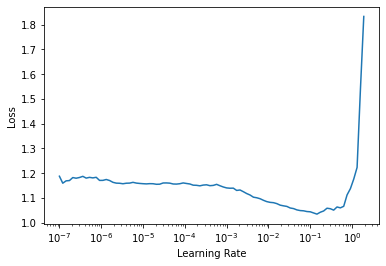

In [110]:
learn.lr_find() # ~ 1e-2

#### Learning
Gradual unfreezing makes a lot of difference!

In [111]:
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2))
#learn.fit(n_epoch=200, lr=2e-2, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=4))

epoch,train_loss,valid_loss,accuracy,time
0,0.889273,0.844193,0.604920,00:05
1,0.799612,0.806843,0.632028,00:05


SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=1.0964781722577754e-06)

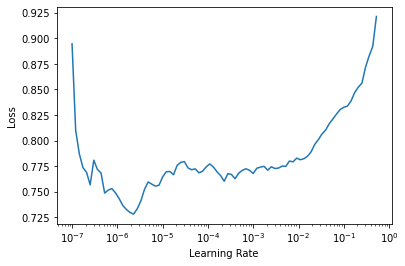

In [112]:
learn.freeze_to(-2)
learn.lr_find()

In [113]:
learn.fit_one_cycle(1, slice(1e-6/(2.6**4),1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.773110,0.806584,0.632028,00:05
1,0.772542,0.805563,0.628012,00:05


SuggestedLRs(lr_min=3.311311302240938e-05, lr_steep=1.5848931980144698e-06)

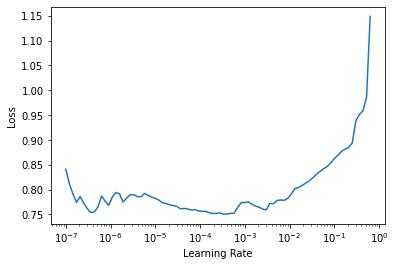

In [114]:
learn.freeze_to(-3)
learn.lr_find()

In [115]:
learn.fit_one_cycle(2, slice(2e-5/(2.6**4),2e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.766461,0.798827,0.627008,00:06
1,0.756232,0.798161,0.633032,00:06
2,0.764927,0.806418,0.625502,00:06


SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=6.309573450380412e-07)

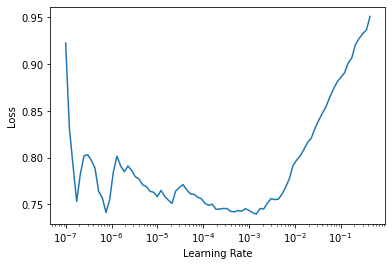

In [116]:
learn.unfreeze()
learn.lr_find()

In [117]:
lr = 4e-6
learn.fit_one_cycle(4, slice(lr/(2.6**4),lr))
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.748636,0.804316,0.634036,00:08
1,0.758426,0.797173,0.631024,00:08
2,0.760907,0.819614,0.633032,00:08
3,0.759113,0.805191,0.630522,00:08


In [118]:
learn.save_encoder('lme_blmbrg_finished')

In [119]:
print("Train Set Accuracy: ",learn.validate()[1]) #0.592 #0.757

Train Set Accuracy:  0.6305220723152161


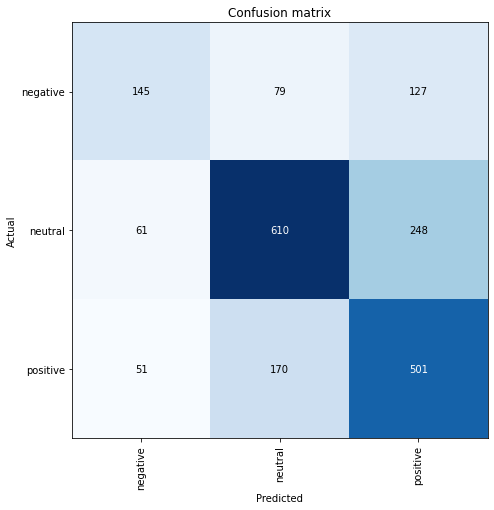

In [120]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data_clas.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

In [121]:
interp.plot_top_losses(6, heatmap=True)

,input,target,predicted,probability,loss
0,"xxbos xxmaj the terms of the financing were approved by the xxmaj annual xxmaj general xxmaj meeting of the xxmaj company held on xxmaj june , .",positive,neutral,0.982657253742218,4.622470855712891
1,"xxbos xxmaj known as xxmaj post xxmaj bank , the concept would see xxmaj fidelity xxmaj bank rolling out offices in xxmaj ghana xxmaj post premises , to provide financial services to the people .",positive,neutral,0.96610426902771,4.108880996704102
2,"xxbos xxmaj the itunes - based material will be accessible on xxmaj windows - based or xxmaj macintosh computers and transferable to portable devices , including xxmaj apple 's xxunk .",positive,neutral,0.9724562764167786,4.011155128479004
3,xxbos added more here,neutral,positive,0.6596812009811401,3.7776241302490234
4,xxbos closing red,neutral,positive,0.51781165599823,3.4356284141540527
5,"xxbos xxmaj following the transaction , xxmaj xxunk has worldwide rights for xxunk , excluding xxmaj north xxmaj america , xxmaj mexico , xxmaj turkey and south - korea .",positive,neutral,0.9619857668876648,3.4318618774414062


### Accuracy on the Test set

In [122]:
test_dl = learn.dls.test_dl(df_test)
preds, y = learn.get_preds()

In [123]:
dl_test = learn.dls.test_dl(df_test, with_labels=True, drop_last=False)
preds = learn.get_preds(dl=dl_test, with_decoded=True)
predictions = preds[2]
targets = preds[1]

In [124]:
def my_accuracy(y_pred, y_true):
    equ = [1 if i == t else 0 for i, t in zip(y_pred, y_true)]
    return np.mean(equ)

In [125]:
acc = my_accuracy(predictions, targets)
print("Test Set Accuracy: ",acc) #0.723

Test Set Accuracy:  0.5592028135990621


In [126]:
interp.plot_top_losses(6, heatmap=True)

,input,target,predicted,probability,loss
0,"xxbos xxmaj the terms of the financing were approved by the xxmaj annual xxmaj general xxmaj meeting of the xxmaj company held on xxmaj june , .",positive,neutral,0.982657253742218,4.622470855712891
1,"xxbos xxmaj known as xxmaj post xxmaj bank , the concept would see xxmaj fidelity xxmaj bank rolling out offices in xxmaj ghana xxmaj post premises , to provide financial services to the people .",positive,neutral,0.96610426902771,4.108880996704102
2,"xxbos xxmaj the itunes - based material will be accessible on xxmaj windows - based or xxmaj macintosh computers and transferable to portable devices , including xxmaj apple 's xxunk .",positive,neutral,0.9724562764167786,4.011155128479004
3,xxbos added more here,neutral,positive,0.6596812009811401,3.7776241302490234
4,xxbos closing red,neutral,positive,0.51781165599823,3.4356284141540527
5,"xxbos xxmaj following the transaction , xxmaj xxunk has worldwide rights for xxunk , excluding xxmaj north xxmaj america , xxmaj mexico , xxmaj turkey and south - korea .",positive,neutral,0.9619857668876648,3.4318618774414062


In [127]:
from sklearn.metrics import confusion_matrix
confusion_matrix(targets, predictions)

array([[ 391,  248,  490],
       [ 224,  630,  878],
       [ 140,  276, 1841]])